# Explaining Models with SHAP
* Jacob Wang
* Coding Dojo Project 1 Revisited - Part 2
* 1/26/2023

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

# Load objects with joblib

In [2]:
f = "../Models/best_models.joblib"
loaded = joblib.load(f)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [3]:
# save loaded objects as varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

## Recreate X_train and X_test

In [4]:
## Get feature names 
feature_names = preprocessor.get_feature_names_out()


## preprocess X_train and X_test
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Fat_Content_Low Fat  \
8269        7.220         0.064142   61.2510                       0.0   
7604        6.135         0.079294  111.2860                       1.0   
2762       12.150         0.028593  151.0708                       1.0   
6464        5.945         0.093009  127.8652                       1.0   
4707       18.200         0.066285  247.2092                       0.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
8269                       1.0                     1.0               0.0   
7604                       0.0                     0.0               0.0   
2762                       0.0                     0.0               0.0   
6464                       0.0                     0.0               0.0   
4707                       1.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
8269                  0.0               0.0              0.0  ...   
7604                  0.0               0.0              0.0  ...   
2762                  0.0               0.0              0.0  ...   
6464                  0.0               0.0              0.0  ...   
4707                  0.0               0.0              0.0  ...   

      Outlet_Size_Medium  Outlet_Size_Missing  Outlet_Size_Small  \
8269                 0.0                  1.0                0.0   
7604                 1.0                  0.0                0.0   
2762                 0.0                  0.0                1.0   
6464                 0.0                  0.0                1.0   
4707                 0.0                  0.0                1.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
8269                          0.0                          0.0   
7604                          0.0                          0.0   
2762                          0.0                          1.0   
6464                          0.0                          1.0   
4707                          0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
8269                          1.0                        1.0   
7604                          1.0                        0.0   
2762                          0.0                        0.0   
6464                          0.0                        0.0   
4707                          0.0                        0.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
8269                            0.0                            0.0   
7604                            0.0                            1.0   
2762                            1.0                            0.0   
6464                            1.0                            0.0   
4707                            1.0                            0.0   

      Outlet_Type_Supermarket Type3  
8269                            0.0  
7604                            0.0  
2762                            0.0  
6464                            0.0  
4707                            0.0  

[5 rows x 32 columns]

In [5]:
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

## Summary plot (Dot)


In [6]:
# Import and init shap
import shap
shap.initjs()

In [7]:
# Take a sample of the training data 
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Fat_Content_Low Fat  \
4469         7.72             0.07     76.40                      0.00   
4438         5.11             0.03    163.82                      1.00   
366          8.05             0.08    256.46                      0.00   
2219         8.76             0.05    128.33                      1.00   
6080         6.59             0.18     82.79                      1.00   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
4469                      1.00                    0.00              1.00   
4438                      0.00                    0.00              0.00   
366                       1.00                    0.00              0.00   
2219                      0.00                    0.00              0.00   
6080                      0.00                    0.00              0.00   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
4469                 0.00              0.00             0.00  ...   
4438                 0.00              0.00             0.00  ...   
366                  0.00              0.00             0.00  ...   
2219                 0.00              0.00             0.00  ...   
6080                 0.00              0.00             0.00  ...   

      Outlet_Size_Medium  Outlet_Size_Missing  Outlet_Size_Small  \
4469                0.00                 0.00               0.00   
4438                0.00                 0.00               1.00   
366                 0.00                 0.00               1.00   
2219                1.00                 0.00               0.00   
6080                0.00                 1.00               0.00   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
4469                         0.00                         0.00   
4438                         0.00                         1.00   
366                          0.00                         1.00   
2219                         1.00                         0.00   
6080                         0.00                         0.00   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
4469                         1.00                       0.00   
4438                         0.00                       0.00   
366                          0.00                       0.00   
2219                         0.00                       0.00   
6080                         1.00                       1.00   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
4469                           1.00                           0.00   
4438                           1.00                           0.00   
366                            1.00                           0.00   
2219                           1.00                           0.00   
6080                           0.00                           0.00   

      Outlet_Type_Supermarket Type3  
4469                           0.00  
4438                           0.00  
366                            0.00  
2219                           0.00  
6080                           0.00  

[5 rows x 32 columns]

In [8]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
shap_values = explainer(X_shap,y_shap)

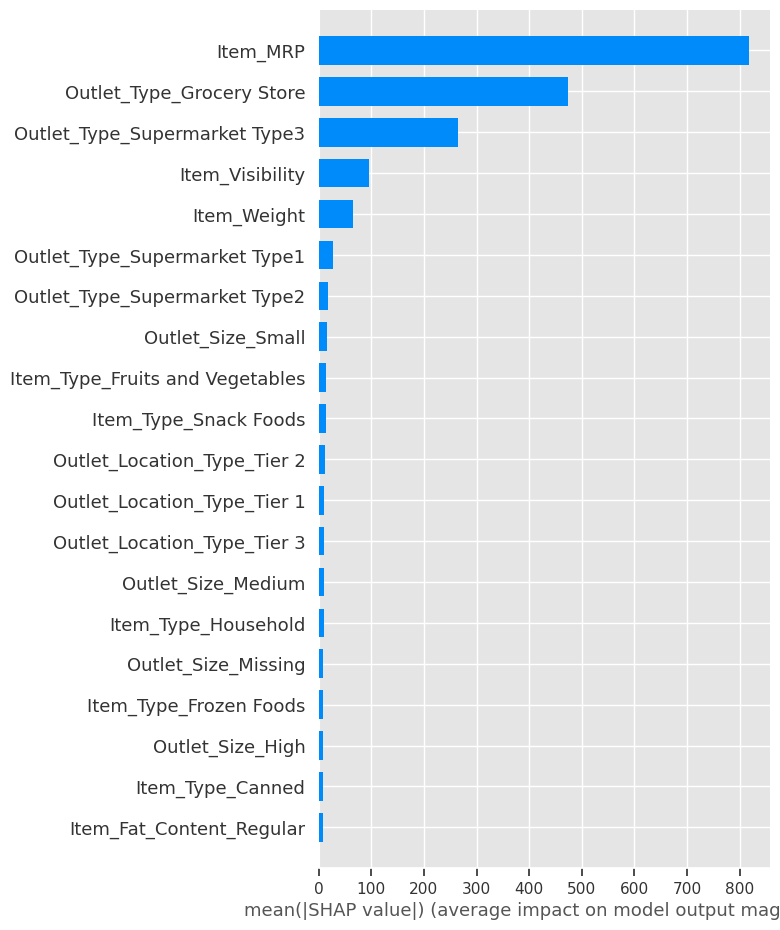

<Figure size 640x480 with 0 Axes>

In [9]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')
plt.savefig('sumPlot_bar', dpi=300)

## Compare to random forest feature importances
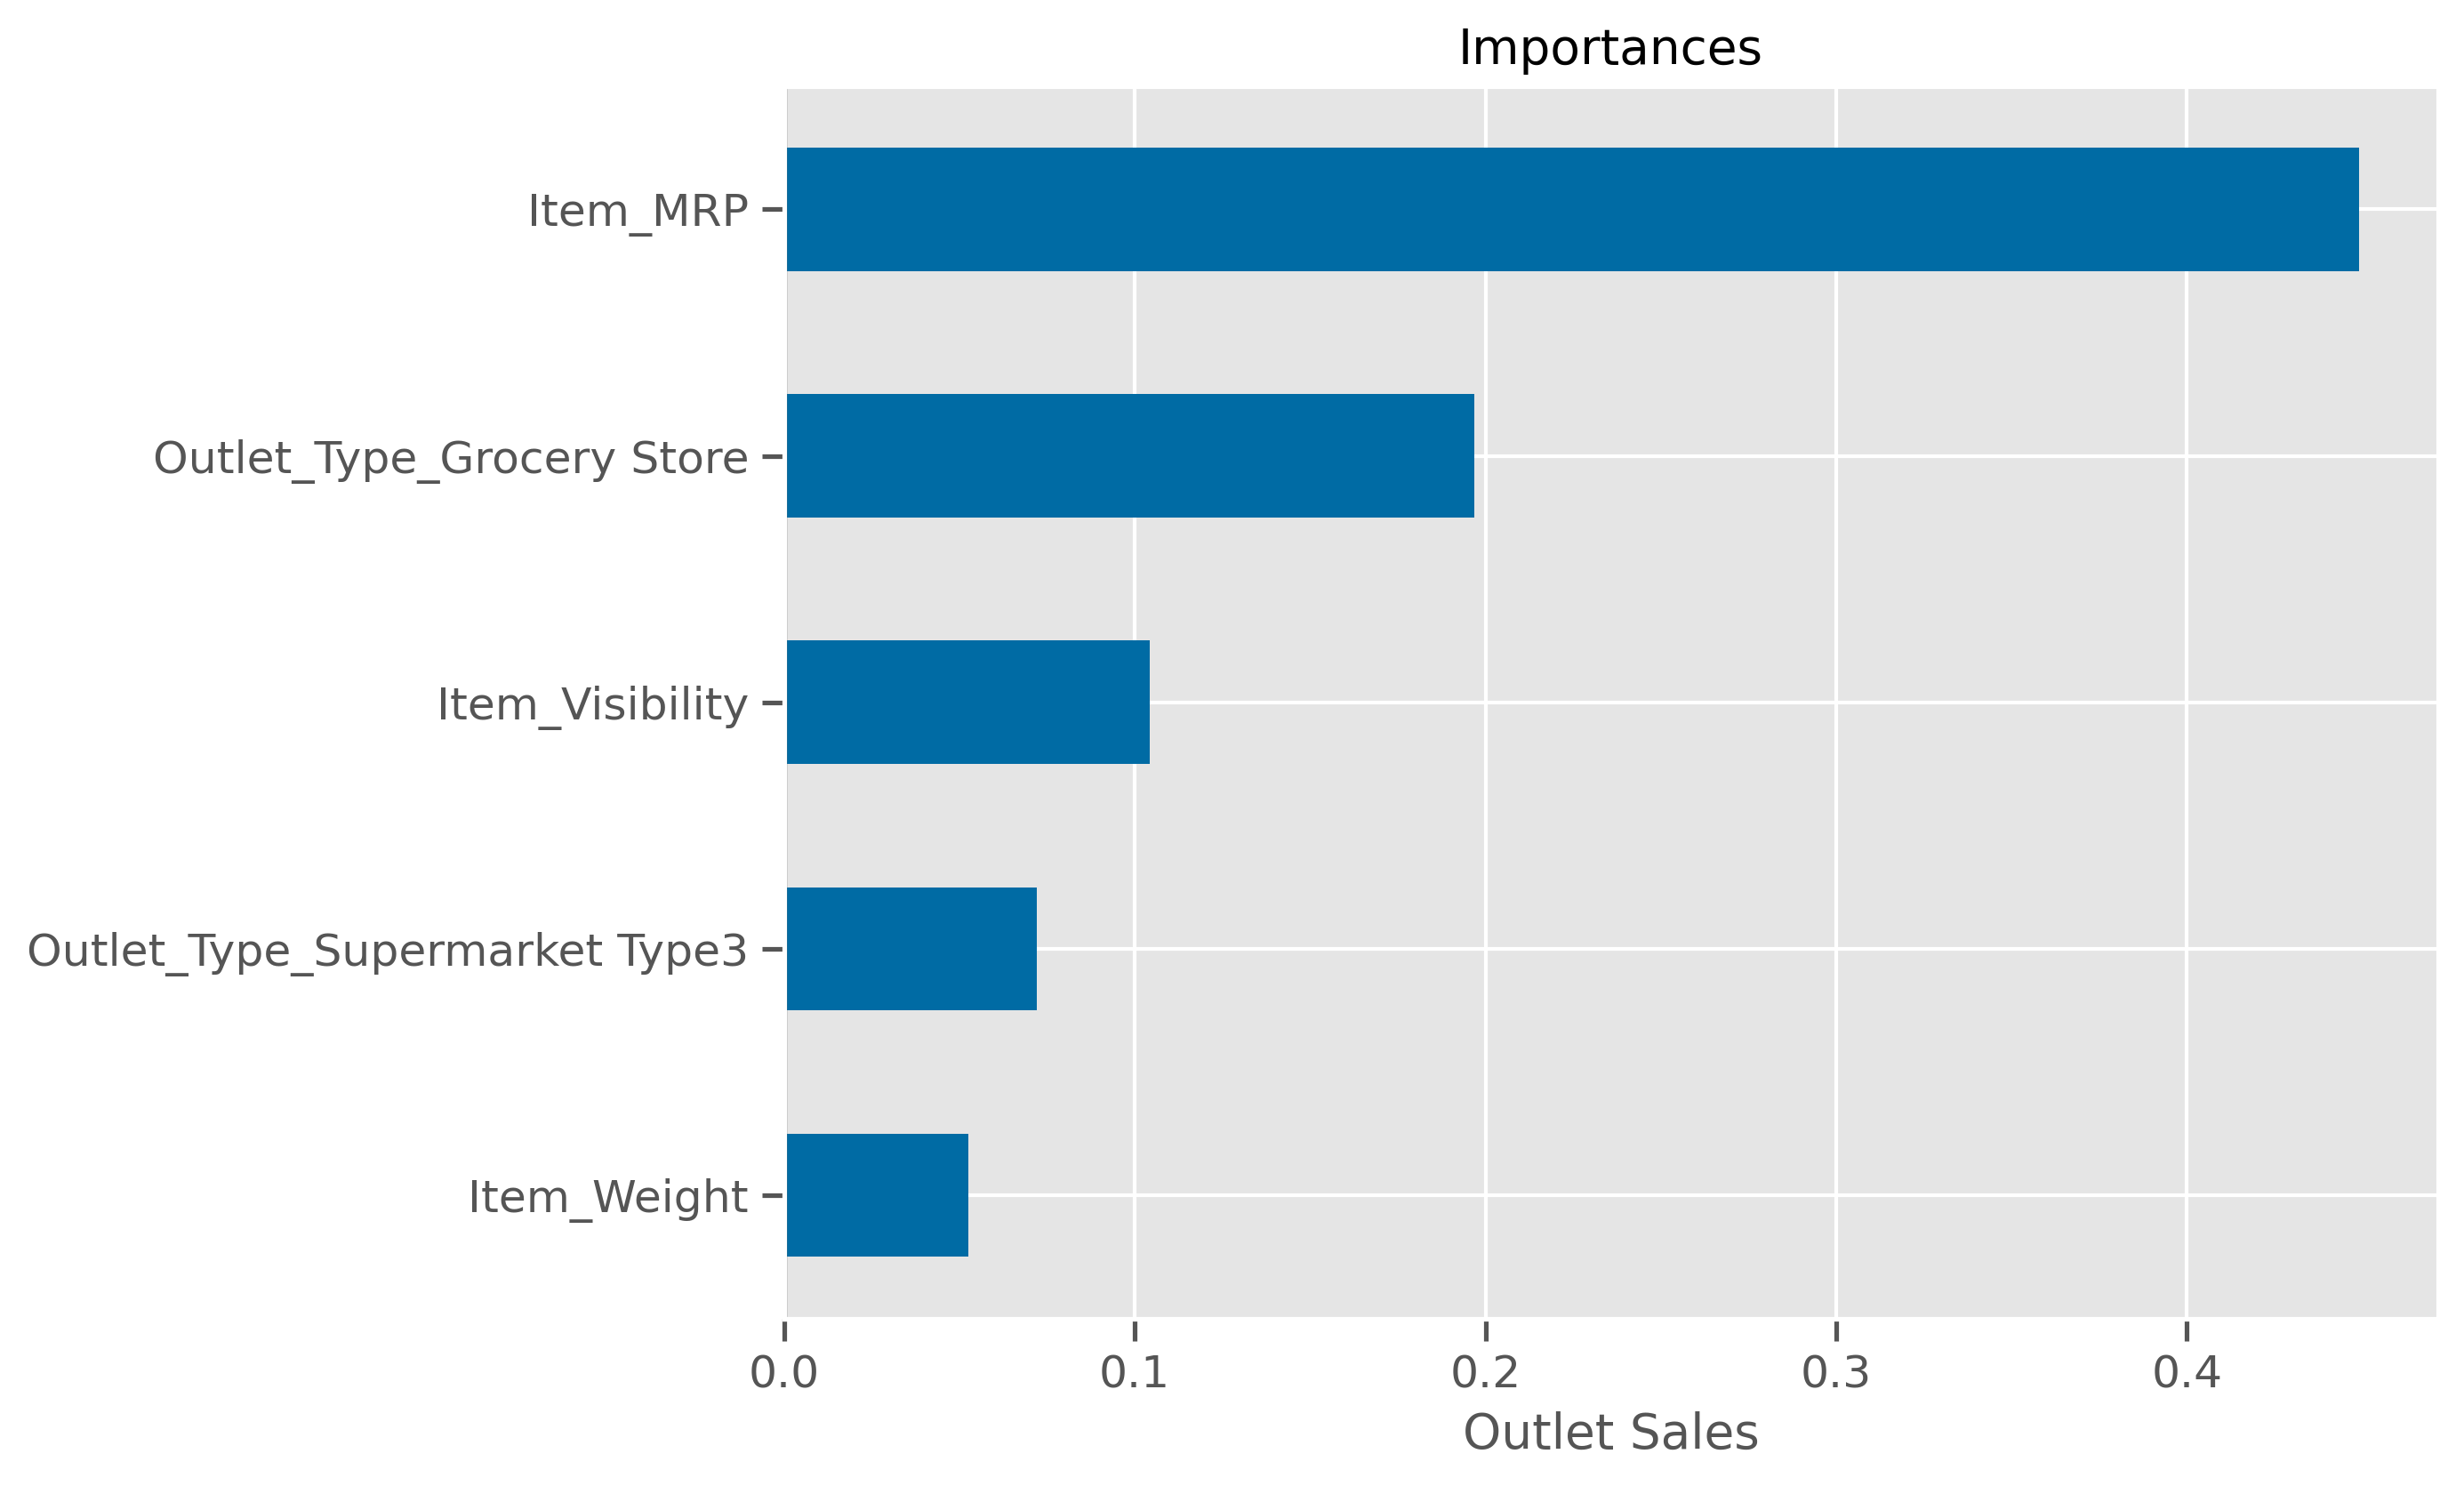
* Many of the same features are found in these two importance graphs. 
* The only variation in the top 5 is that permutation importances include Item_Type_Household as the 4th most impactful feature. 
    * In contrast, the feature importances include Item_Visibilty as the 3rd most impactful feature and does not include Item_Type_Household
* The permutation importances also have Supermarket_Type3 ranked higher 
    * While Supermarket_Type3 is also present in the top 5 feature importances, it is the 4th most important 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


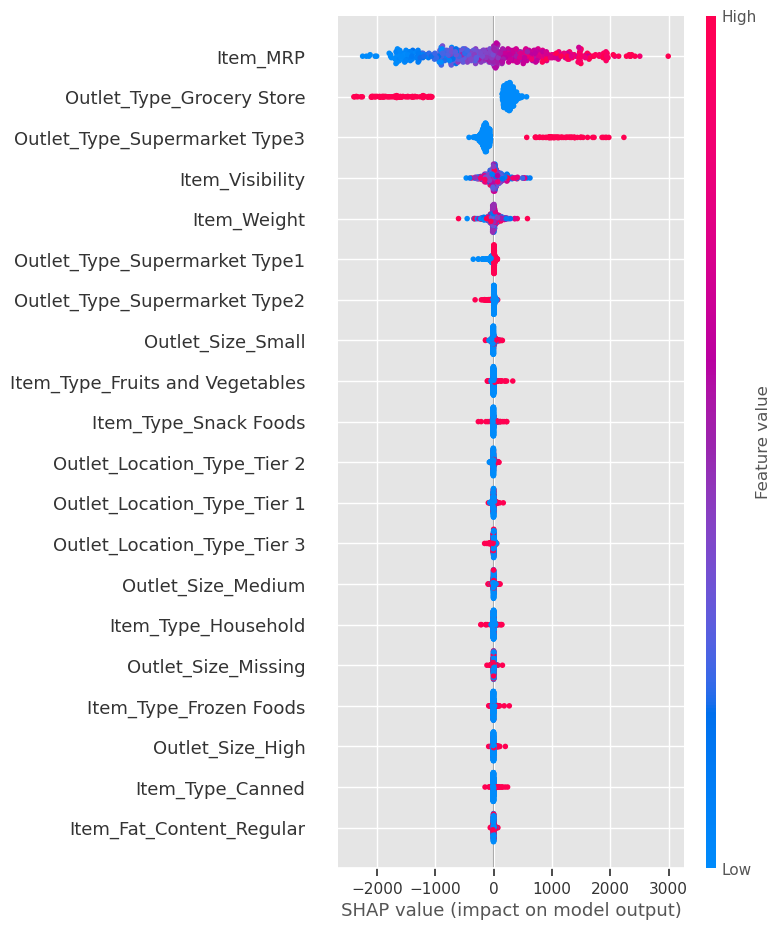

<Figure size 640x480 with 0 Axes>

In [10]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)
plt.savefig('sumPlot_dot', dpi =300)

## Interpret dot plot

* According to our dot plot the Item_MRP is our most impactful feature and very highly correlated with sales.
    * The higher the MRP, the higher the target value (outlet sales)
    * If Item_MRP decreases, so does outlet sales 
* The next most impactful feature is whether or not the store in question is a grocery store.
    * If it is, sales are expected to drop dramatically. If not, then sales will likely increase.
* Our 3rd most impactful feature is whether or not the store is a Supermarket Type3. 
    * Supermarkets (and especially those that are type3) produce much higher sales than grocery stores. 


# Local Explanations

In [11]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Fat_Content_Low Fat  \
0         7.72             0.07     76.40                      0.00   
1         5.11             0.03    163.82                      1.00   
2         8.05             0.08    256.46                      0.00   
3         8.76             0.05    128.33                      1.00   
4         6.59             0.18     82.79                      1.00   

   Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
0                      1.00                    0.00              1.00   
1                      0.00                    0.00              0.00   
2                      1.00                    0.00              0.00   
3                      0.00                    0.00              0.00   
4                      0.00                    0.00              0.00   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
0                 0.00              0.00             0.00  ...   
1                 0.00              0.00             0.00  ...   
2                 0.00              0.00             0.00  ...   
3                 0.00              0.00             0.00  ...   
4                 0.00              0.00             0.00  ...   

   Outlet_Size_Medium  Outlet_Size_Missing  Outlet_Size_Small  \
0                0.00                 0.00               0.00   
1                0.00                 0.00               1.00   
2                0.00                 0.00               1.00   
3                1.00                 0.00               0.00   
4                0.00                 1.00               0.00   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                         0.00                         0.00   
1                         0.00                         1.00   
2                         0.00                         1.00   
3                         1.00                         0.00   
4                         0.00                         0.00   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                         1.00                       0.00   
1                         0.00                       0.00   
2                         0.00                       0.00   
3                         0.00                       0.00   
4                         1.00                       1.00   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                           1.00                           0.00   
1                           1.00                           0.00   
2                           1.00                           0.00   
3                           1.00                           0.00   
4                           0.00                           0.00   

   Outlet_Type_Supermarket Type3  
0                           0.00  
1                           0.00  
2                           0.00  
3                           0.00  
4                           0.00  

[5 rows x 32 columns]

## First example: Highest store sales

In [12]:
y_shap_local.describe()

count     500.00
mean    2,149.72
std     1,720.63
min        36.62
25%       747.53
50%     1,763.70
75%     3,043.04
max     9,371.80
Name: Item_Outlet_Sales, dtype: float64

In [13]:
idx_max_sales = y_shap_local.idxmax()
idx_max_sales

482

In [14]:
## what was the store's sales?
y_shap_local.iloc[idx_max_sales]

9371.8008

### SHAP Force plot

In [15]:
## plotting example force plot for highest store sales
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_max_sales].values,
               features=X_shap_local.iloc[idx_max_sales])

In [19]:
# what is the max/range of item price
X_shap_local['Item_MRP'].describe()

count   500.00
mean    137.08
std      61.60
min      32.36
25%      90.08
50%     140.43
75%     179.52
max     264.72
Name: Item_MRP, dtype: float64

### Interpret SHAP Force plot
* According to our force plot, the base value for sales is 2,156 rupees. 
* The store sales for this particular example is 8,422.74 rupees.
* The most influential factors that contributed to increasing store sales were the Item_MRP, the fact that the store was a Supermarket Type3, and that it was NOT a grocery store. 
    * The Item_MRP for this example was one of the highest item price values we have (260.6) 
       * The max Item_MRP was 264.72

### LIME 


In [20]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [21]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_max_sales],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


### Interpret LIME: 
* According to our LIME Explanation, the most important feature that contributed to our model's prediction was that the store in question was NOT a grocery store.
* The Item_MRP was the second most influential feature - this makes sense as a higher MRP typically yielded higher sales 
    * Our expected sales value (8,422.74) is one of the higher store sales amounts
* The store being a Supermarket Type3 also contributed heavily to the high sales value

## Second Example: Lowest Store Sales

In [16]:
idx_min_sales = y_shap_local.idxmin()
idx_min_sales

178

In [17]:
## what was the store's sales?
y_shap_local.iloc[idx_min_sales]


36.619

### SHAP Force plot

In [18]:
## plotting example force plot for lowest store sales
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_min_sales].values,
               features=X_shap_local.iloc[idx_min_sales])

### Interpret SHAP Force plot
* This example yielded an expected sales value close to the lowest observed sales amount
* The fact that the store was a grocery store and that the Item_MRP was one of the lowest contributed the most to the low sales value

### LIME

In [22]:
## Use the lime explainer to explain the low-sales example 
exp_low_sales = lime_explainer.explain_instance(X_shap_local.loc[idx_min_sales],
                                      rf_reg.predict)
exp_low_sales.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


### Interpret LIME Explanation
* According to our LIME Explanation, the example in question returned such a low sales value mainly because the store was a grocery store.
* The Item_MRP value being close to the minimum value observed also contributed heavily to the low sales amount
* The fact that the store in question was NOT a Supermarket Type3 was also very influential in the model's prediction